In [ ]:
conda install -c conda-forge python-igraph

In [1]:
import igraph
import xml.etree.ElementTree as ElementTree
import numpy as np
from tqdm.notebook import tqdm
from scipy.spatial.transform import Rotation
from joblib import Parallel, delayed
import pickle

%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# define a mapping from single letter amino acid codes to three letter abbreviations
mappings = ('ala:A|arg:R|asn:N|asp:D|cys:C|gln:Q|glu:E|gly:G|his:H|ile:I|leu:L|lys:K|met:M|phe:F|pro:P|ser:S|thr:T|trp:W|tyr:Y|val:V').upper().split('|')
letter2aa = dict([m.split(':')[::-1] for m in mappings])

In [3]:
# load an amino acid sequence from a fasta file
with open('proteins/6ct4.fasta') as file:
    fasta = file.read().strip().split('\n')[-1]

res_sequence = 'MALEK'
#res_sequence = fasta
pos_init_range = 3

#print('protein fasta:', res_sequence)

atoms = []
bonds = []
external_bond_indices = []
# load the amber forcefield
forcefield = ElementTree.parse('forcefields/amber99sb.xml').getroot()

# iterate over the amino acids in the sequence and load details from the forcefield
for i, res in enumerate(tqdm(res_sequence, desc='loading atom and force definitions from the forcefield', ncols=850)):
    external_bond_indices.append([])
    atom_count = len(atoms)

    # get the three letter code from the current amino acid letter
    aa_name = letter2aa[res]
    if i == 0:
        # add an N to the first residue to signal that hydrogen has to be added to the amine group
        aa_name = 'N' + aa_name
    elif i == len(res_sequence) - 1:
        # add a C to the last residue to signal that a terminal oxygen has to be added to the carboxyl group
        aa_name = 'C' + aa_name

    # iterate over the children for the current residue defined in the forcefield
    for obj in forcefield.find(f'Residues/Residue[@name=\'{aa_name}\']'):
        if obj.tag == 'Atom':
            # processing an atom of the current residue
            name = obj.get('name')
            type_id = int(obj.get('type'))
            # get the type traits for the current atom
            atom_traits = forcefield[0][type_id].attrib
            atom_class = atom_traits['class']
            element = atom_traits['element']
            mass = float(atom_traits['mass'])
            # extract information about nonbonded forces for this atom
            nonbonded_traits = forcefield[5][type_id].attrib
            charge = float(nonbonded_traits.get('charge'))
            sigma = float(nonbonded_traits.get('sigma'))
            epsilon = float(nonbonded_traits.get('epsilon'))
            # initialize the position randomly, could add more options here
            pos = np.random.uniform(0, pos_init_range, size=3)
            # add a dictionary containing all information about the atom to the atom list
            atoms.append(dict(name=name, type_id=type_id, atom_class=atom_class, element=element,
                              index=len(atoms), residue_index=i, residue=aa_name, mass=mass,
                              charge=charge, sigma=sigma, epsilon=epsilon, pos=pos))
        elif obj.tag == 'Bond':
            # processing a harmonic bond in the current residue
            from_index = atom_count + int(obj.get('from'))
            to_index = atom_count + int(obj.get('to'))
            # get the atoms between the bond exists, atoms for the current residue should be fully loaded
            # at this point due to the ordering in the forcefield xml
            from_atom = atoms[from_index]
            to_atom = atoms[to_index]
            # find the bond force definition for the current bond in the forcefield
            bond = forcefield.find(f'HarmonicBondForce/Bond[@class1=\'{from_atom["atom_class"]}\'][@class2=\'{to_atom["atom_class"]}\']')
            if bond is None:
                # try again with the atom classes in the reversed order
                bond = forcefield.find(f'HarmonicBondForce/Bond[@class1=\'{to_atom["atom_class"]}\'][@class2=\'{from_atom["atom_class"]}\']')
            # add a dictionary containing all information about the current bond the the bond list
            bonds.append(dict(from_index=from_index, to_index=to_index, length=float(bond.get('length')),
                              k=float(bond.get('k')), bond_type='internal'))
        elif obj.tag == 'ExternalBond':
            # add the atom indices of external bonding sites to the list
            from_index = atom_count + int(obj.get('from'))
            external_bond_indices[-1].append(dict(from_index=from_index))
           
    if i > 0:
        # create an external bond definition (bond between two residues)
        from_index = external_bond_indices[i-1][-1]['from_index']
        to_index = external_bond_indices[i][0]['from_index']
        # get the involved atoms
        from_atom = atoms[from_index]
        to_atom = atoms[to_index]
        # find the force definition for the current bond
        bond = forcefield.find(f'HarmonicBondForce/Bond[@class1=\'{from_atom["atom_class"]}\'][@class2=\'{to_atom["atom_class"]}\']')
        if bond is None:
            # try again with the atom classes in the reversed order
            bond = forcefield.find(f'HarmonicBondForce/Bond[@class1=\'{to_atom["atom_class"]}\'][@class2=\'{from_atom["atom_class"]}\']')
        # add the external bond to the bond list
        bonds.append(dict(from_index=from_index, to_index=to_index, length=float(bond.get('length')),
                          k=float(bond.get('k')), bond_type='external'))

loading atom and force definitions from the forcefield:   0%|                                                 …

In [4]:
def draw_graph(g, error_scale=3, draw_names='backbone'):
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='3d')

    # create the atom name list if backbone visualization was chosen
    if draw_names == 'backbone':
        draw_names = ['N', 'CA', 'C']
    
    # draw the edges
    for edge in g.es:
        name1 = edge.source_vertex['name']
        name2 = edge.target_vertex['name']
        # filter out atoms that are not in the draw_names list
        if draw_names is not None and (name1 not in draw_names or name2 not in draw_names):
            continue
            
        pos1 = edge.source_vertex['pos']
        pos2 = edge.target_vertex['pos']
        # get the length error of the bond and get the corresponding color value
        error = np.minimum(1, np.abs(np.linalg.norm(pos2 - pos1) - e['length']) * error_scale)
        ax.plot([pos1[0], pos2[0]], [pos1[1], pos2[1]], [pos1[2], pos2[2]], c=(error, (1 - error), 0))

    # create a dict with residue names as keys and the corresponding atoms as values
    vertex_dict = {}
    for vertex in g.vs:
        res = f'{vertex["residue_index"] + 1} - {vertex["residue"]}'
        if res in vertex_dict:
            vertex_dict[res].append(vertex)
        else:
            vertex_dict[res] = [vertex]
            
    # draw vertices with names defined by draw_names
    for res, vertices in vertex_dict.items():
        pos = np.array([vertex['pos'] for vertex in vertices if draw_names is None or vertex['name'] in draw_names])
        ax.plot(pos[:,0], pos[:,1], pos[:,2], 'o', label=res)
        
    plt.legend()
    plt.tight_layout()
    plt.show()

In [5]:
graph = igraph.Graph()
# add all atoms to the graph as vertices
for atom in atoms:
    v = graph.add_vertex(atom['name'])
    v.update_attributes(atom)
   # print('atoms',atom)
# all all harmonic distance bonds between atoms to the graph as edges
for bond in bonds:
    e = graph.add_edge(graph.vs[bond['from_index']], graph.vs[bond['to_index']])
    e.update_attributes(bond)

angle_bonds = []
for e in graph.es:
    # get the two vertices of the current edge
    bond_tuple = [e.source, e.target]
    # iterate over the source vertex neighbours
    for vertex in e.source_vertex.neighbors():
        if vertex.index in bond_tuple:
            # skip the vertex if it is part of the current edge
            continue
        # define the vertex triplet for the current angle bond
        triplet = [vertex.index] + bond_tuple
        classes = [graph.vs[triplet[0]]['atom_class'],
                   graph.vs[triplet[1]]['atom_class'],
                   graph.vs[triplet[2]]['atom_class']]
        
        # find the angle force definition for the current triplet in the forcefield
        bond = forcefield.find(f'HarmonicAngleForce/Angle[@class1=\'{classes[0]}\'][@class2=\'{classes[1]}\'][@class3=\'{classes[2]}\']')
        if bond is None:
            # reverse the atom order and try again
            bond = forcefield.find(f'HarmonicAngleForce/Angle[@class1=\'{classes[2]}\'][@class2=\'{classes[1]}\'][@class3=\'{classes[0]}\']')

        # add a dictionary containing all bond information to the list
        angle = float(bond.get('angle'))
        k = float(bond.get('k'))
        angle_bonds.append(dict(index1=triplet[0], index2=triplet[1], index3=triplet[2], angle=angle, k=k))
        
nonbonded = []
for i, a1 in enumerate(tqdm(graph.vs, desc='loading nonbonded atom interactions', ncols=850)):
    for a2 in graph.vs[i+1:]:
        sigma = (a1['sigma'] + a2['sigma']) / 2
        sigma7 = sigma ** 7
        sigma13 = sigma ** 13
        epsilon = 4 * np.sqrt(a1['epsilon'] * a2['epsilon'])
        coulomb = a1['charge'] * a2['charge'] # this should be mutliplied by the Coulomb constant
        
        nb = lambda r: epsilon * ((sigma / r) ** 12 - (sigma / r) ** 6)# + (coulomb / (r ** 2))
        xs = np.linspace(2e-1, 1, 10000)
        arg = np.argmin(nb(xs))
        
        nonbonded.append(dict(index1=a1.index, index2=a2.index,
                              sigma7=sigma7, sigma13=sigma13,
                              epsilon=epsilon, coulomb=coulomb, length=xs[arg]))


loading nonbonded atom interactions:   0%|                                                                    …

<IPython.core.display.Javascript object>


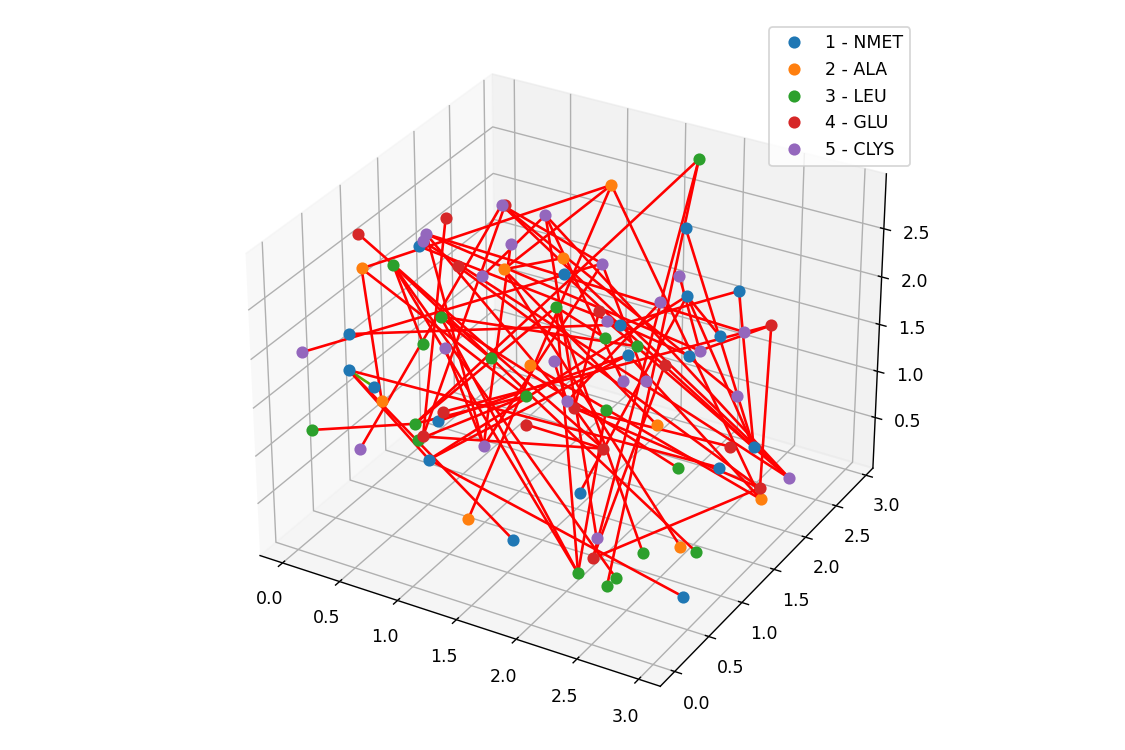

[0.33312369 0.24992659 1.79649332]
igraph.Vertex(<igraph.Graph object at 0x0000019B1DD3BC70>, 0, {'name': 'N', 'type_id': 909, 'atom_class': 'N3', 'element': 'N', 'index': 0, 'residue_index': 0, 'residue': 'NMET', 'mass': 14.00672, 'charge': 0.1592, 'sigma': 0.324999852378, 'epsilon': 0.71128, 'pos': array([0.33312369, 0.24992659, 1.79649332])})


In [6]:
draw_graph(graph, draw_names=None)
print(graph.vs[0]['pos'])
print(graph.vs[0])


In [7]:
def bfs(graph, vid, max_dist=None):
    # run a breadth first search up to a maximum distance and save the detection order and parents
    order, parents = [], []
    for v, dist, parent in graph.bfsiter(vid, advanced=True):
        if max_dist is not None and dist > max_dist:
            # reached maximum distance, stop the search
            break
        order.append(v.index)
        parents.append(parent.index if parent is not None else -1)
    return (order, parents)

def remove_bfs_vertex(vid, order, parents):
    # remove the current vertex
    if vid in order:
        order[np.argwhere(order == vid)[0,0]] = -1
    # recursive calls to remove all vertices of which the current one is a parent
    for index in np.argwhere(parents == vid):
        remove_bfs_vertex(order[index], order, parents)

# maximum distance from the bond to be influenced
max_dist = None

# generate influence lists for each harmonic DISTANCE bond, containing the connected vertices up to max_dist
for e in tqdm(graph.es, desc='computing influence radii for harmonic distance bonds', ncols=850):
    # run a breadth-first-search to get all connected vertices on the SOURCE side of the bond
    result = bfs(graph, e.source, max_dist=max_dist)
    order, parents = np.array(result[0]), np.array(result[1])
    # remove all vertices "behind" the bond
    remove_bfs_vertex(e.target, order, parents)
    e.update_attributes(source_influence=list(order[order != -1]))
    
    # run a breadth-first-search to get all connected vertices on the TARGET side of the bond
    result = bfs(graph, e.target, max_dist=max_dist)
    order, parents = np.array(result[0]), np.array(result[1])
    # remove all vertices "behind" the bond
    remove_bfs_vertex(e.source, order, parents)
    e.update_attributes(target_influence=list(order[order != -1]))
    
# generate influence lists for each harmonic ANGLE bond, containing the connected vertices up to max_dist
for angle in tqdm(angle_bonds, desc='computing influence radii for harmonic angle bonds', ncols=850):
    result = bfs(graph, angle['index1'], max_dist=max_dist)
    order, parents = np.array(result[0]), np.array(result[1])
    remove_bfs_vertex(angle['index2'], order, parents)
    angle['idx1_influence'] = list(order[order != -1])
    
    result = bfs(graph, angle['index3'], max_dist=max_dist)
    order, parents = np.array(result[0]), np.array(result[1])
    remove_bfs_vertex(angle['index2'], order, parents)
    angle['idx3_influence'] = list(order[order != -1])

computing influence radii for harmonic distance bonds:   0%|                                                  …

computing influence radii for harmonic angle bonds:   0%|                                                     …

In [8]:
length_summ = []
angle_summ = []
nonbonded_summ = []

In [9]:
length_step_size = 0.1
angle_step_size = 0.1
nonbonded_step_size = 0#0.001
steps = 50

def process_dist_bond(e, source_pos, target_pos):
    # initialize offsets for each vertex
    offsets = np.zeros((len(graph.vs), 3))
    # get the vector and distance from the source to the target
    vec = target_pos - source_pos
    dist = np.linalg.norm(vec)
    # compute the current error in the distance
    error = dist - e['length']
    # iterate over all vertices connected to the source vertex
    for v in e['source_influence']:
        offsets[v] += vec / dist * error / 2
    # iterate over all vertices connected to the target vertex
    for v in e['target_influence']:
        offsets[v] -= vec / dist * error / 2
    return offsets, abs(error)

def process_angle_bond(a):
    points = [graph.vs[a['index1']]['pos'], graph.vs[a['index2']]['pos'], graph.vs[a['index3']]['pos']]
    # initialize offsets for each vertex
    offsets = np.zeros((len(graph.vs), 3))
    # get the angle between the three points
    s1 = points[0] - points[1]
    s2 = points[2] - points[1]
    angle = np.arccos(np.dot(s1, s2) / (np.linalg.norm(s1) * np.linalg.norm(s2)))
    # get the current angle's error
    angle_error = angle - a['angle']
    # get the rotation axis by computing the face normal of the three points
    rot_axis = np.cross(s1, s2)
    # define the rotation matrix
    rot = Rotation.from_rotvec((angle_error / 2 * angle_step_size) * (rot_axis / np.linalg.norm(rot_axis)))

    origin = points[1]
    # iterate over all vertices connected to angle vertex 1
    for v in a['idx1_influence']:
        pos = graph.vs[v]['pos']
        offsets[v] += rot.apply(pos - origin) + origin - pos
    # iterate over all vertices connected to angle vertex 2
    for v in a['idx3_influence']:
        pos = graph.vs[v]['pos']
        offsets[v] += rot.inv().apply(pos - origin) + origin - pos
    return offsets, abs(angle_error)

def process_nonbonded(nb):
    p1 = graph.vs[nb['index1']]['pos']
    p2 = graph.vs[nb['index2']]['pos']
    vec = p2 - p1
    
    r = np.sqrt(np.sum(vec ** 2))

    '''
    r3 = r ** 3
    r7 = r ** 7
    r13 = r ** 13
    
    lj = nb['epsilon'] * (6 * nb['sigma7'] / r7 - 12 * nb['sigma13'] / r13)
    coulomb = -2 * nb['coulomb'] / r3
    err = lj# + coulomb
    if r < 0.05 or r > 2:
        err = 0
    '''
    err = nb['epsilon'] * (r - nb['length'])
    
    return (nb['index1'], vec * err), (nb['index2'], vec * -err)

t = tqdm(total=steps, unit='step', desc='optimizing protein structure', ncols=850)
for step in range(steps):
    total_length_error = 0
    total_angle_error = 0
    total_nonbonded_error = 0
    # initialize offsets for each vertex (length and angle)
    offsets = np.zeros((len(graph.vs), 3))

    
    # compute the vertex offsets for each harmonic DISTANCE bond
    result = Parallel(n_jobs=1, backend='multiprocessing')(
        delayed(process_dist_bond)(e.attributes(), e.source_vertex['pos'], e.target_vertex['pos']) for e in graph.es)

    # unpack the results
    off, err = zip(*result)
    offsets += np.array(off).sum(axis=0) * length_step_size
    total_length_error += np.sum(err)
    # normalize the total length error
    total_length_error /= len(graph.es)
    
    # compute the vertex offsets for each harmonic ANGLE bond
    result = Parallel(n_jobs=1, backend='multiprocessing')(delayed(process_angle_bond)(a) for a in angle_bonds)
    # unpack the results
    off, err = zip(*result)
    offsets += np.array(off).sum(axis=0)
    total_angle_error += np.sum(err)
    # normalize the total angle error
    total_angle_error /= len(angle_bonds)
    
    # compute the vertex offsets for each NON-BONDED atom pair
    result = Parallel(n_jobs=1, backend='multiprocessing')(delayed(process_nonbonded)(nb) for nb in nonbonded)
    for curr in result:
        for index, off in curr:
            offsets[index] += off * nonbonded_step_size
        total_nonbonded_error += abs(np.sum(off ** 2))
    # normalize the total angle error
    total_nonbonded_error /= len(nonbonded)
    
    # apply the offset to the vertex positions
    for v, offset in zip(graph.vs, offsets):
        v['pos'] += offset
    
    length_summ.append(total_length_error)
    angle_summ.append(total_angle_error)
    nonbonded_summ.append(total_nonbonded_error)
    status = dict(length=f'{total_length_error:.3g}',
                  angle=f'{total_angle_error:.3g}',
                  nonbonded=f'{total_nonbonded_error:.3g}')
    t.set_postfix(status)
    t.update()

optimizing protein structure:   0%|                                                                           …

<IPython.core.display.Javascript object>


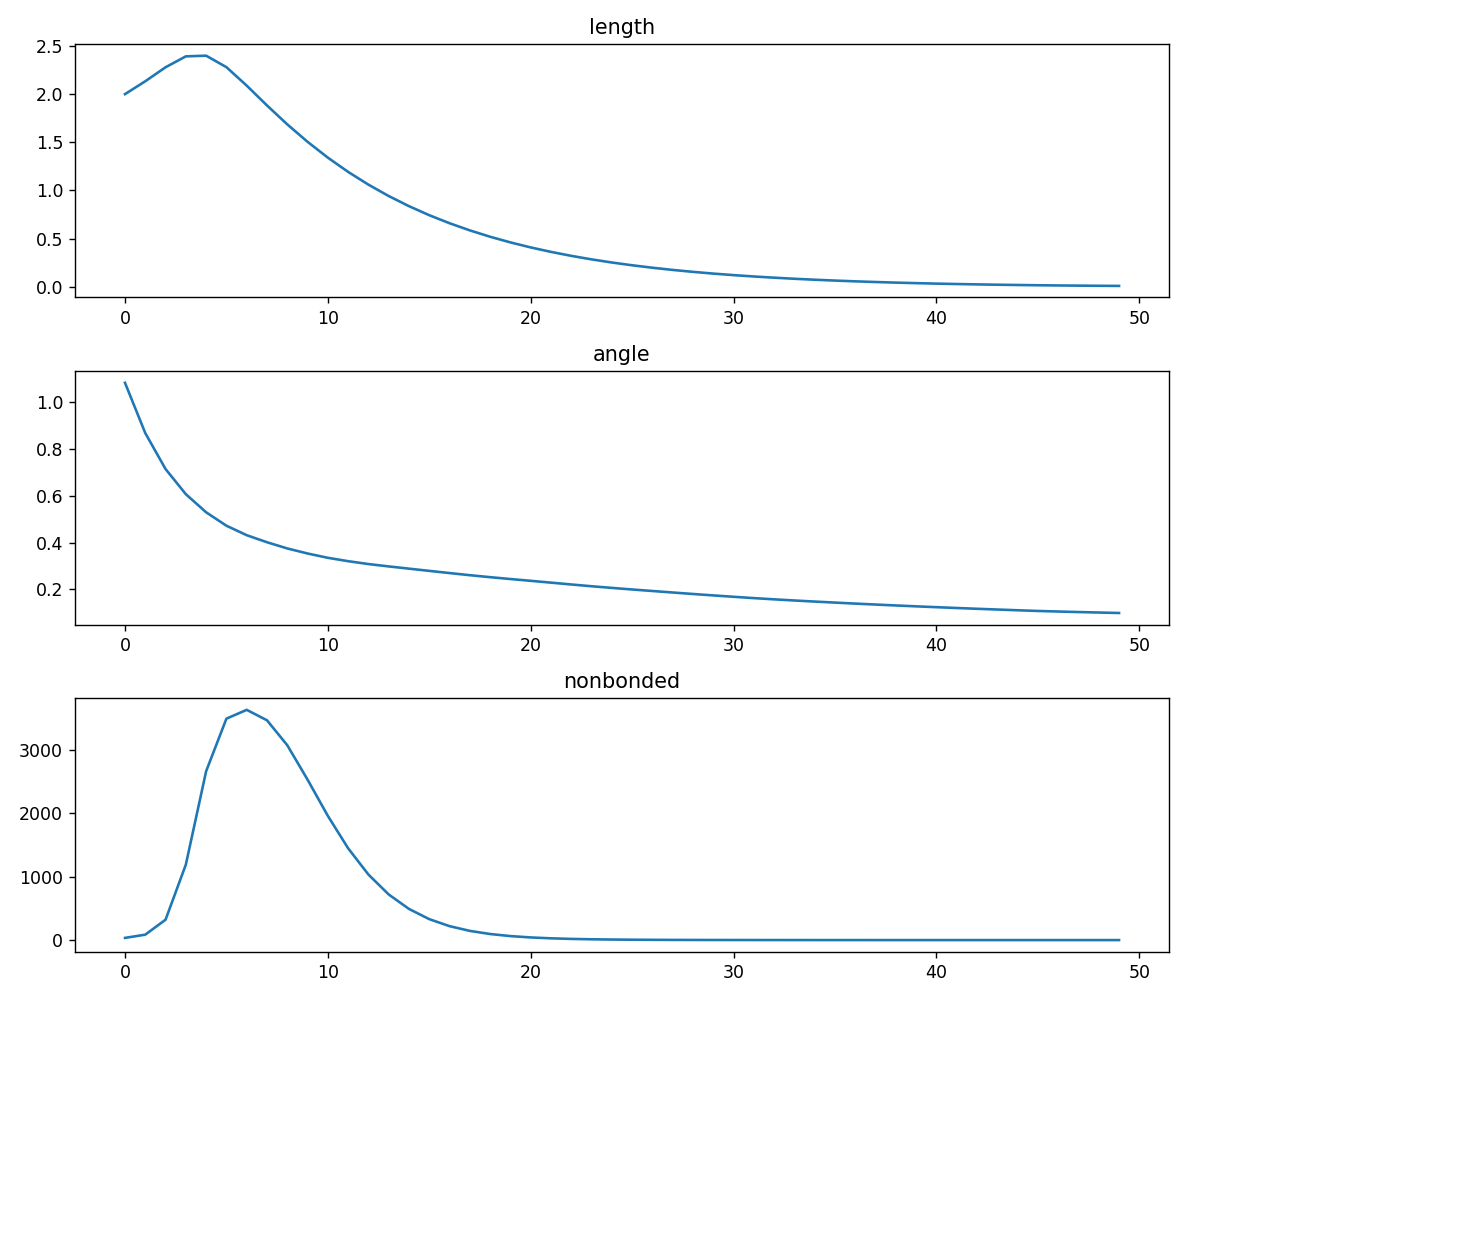

In [10]:
fig, axes = plt.subplots(3, 1, figsize=(9.5, 8))
axes[0].set_title('length')
axes[0].plot(length_summ)
axes[1].set_title('angle')
axes[1].plot(angle_summ)
axes[2].set_title('nonbonded')
axes[2].plot(nonbonded_summ)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


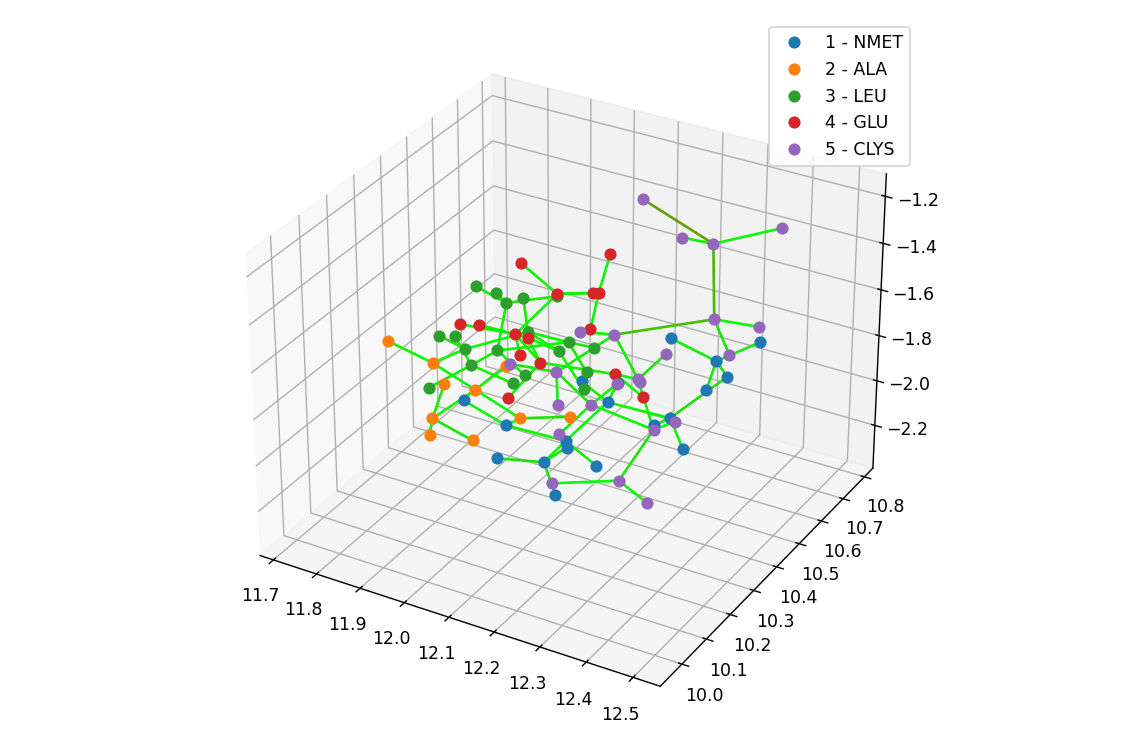

[12.00771767 10.44879613 -2.30784534]


In [11]:
draw_graph(graph, draw_names=None)
print(graph.vs[0]['pos'])